# Projeto Final - Tera - Data Science
Notebooks destinados ao desenvolvimento do projeto final do treinamento Tera - Data Science
## Forecasting
1. Objetivo:
    1. Prever o desempenho do faturamento por loja para definição do baseline
2. Output:
    1. DataSet com as previsões de faturamento por loja

In [1]:
# Bibliotecas Padrões
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Lendo df em csv
df_model = pd.read_csv('../data/df_model.csv', sep=';')

# Transformando coluna de data
df_model.Date = pd.to_datetime(df_model.Date)

# Display
df_model

,Date,IsHoliday,Store,Size,Dept,MarkDown5,Weekly_Sales
0,2010-02-05,0,1,151315,1,0.00,24924.50
1,2010-02-05,0,1,151315,2,0.00,50605.27
2,2010-02-05,0,1,151315,3,0.00,13740.12
3,2010-02-05,0,1,151315,4,0.00,39954.04
4,2010-02-05,0,1,151315,5,0.00,32229.38
...,...,...,...,...,...,...,...
421565,2012-10-26,0,45,118221,93,858.33,2487.80
421566,2012-10-26,0,45,118221,94,858.33,5203.31
421567,2012-10-26,0,45,118221,95,858.33,56017.47
421568,2012-10-26,0,45,118221,97,858.33,6817.48


In [3]:
# Create date feature based on trignometry circle
from datetime import datetime
import math as m

df_model['day_of_year'] = df_model.apply(lambda row: row['Date'].timetuple().tm_yday, axis=1)

angle_by_day = 360/365.25
radius = 1 # valeur x et y entre -1 et 1
rad_convert = m.pi/180

df_model['day_circle_x'] = radius *  np.cos(angle_by_day * df_model['day_of_year'] * rad_convert)
df_model['day_circle_y'] = radius *  np.sin(angle_by_day * df_model['day_of_year'] * rad_convert)

In [4]:
# Create basic date features with seasonality
df_model['Month'] = df_model.Date.dt.month
df_model['Week'] = df_model.Date.dt.weekofyear

In [5]:
# Splitting train & test samples
df_train = df_model[df_model.Date < '2012-01-01']
df_test = df_model[df_model.Date >= '2012-01-01']

In [6]:
X_train = df_train[['day_of_year', 'IsHoliday', 'Store', 'Size', 'Dept', 'MarkDown5']]
y_train = df_train.Weekly_Sales

In [7]:
X_test = df_test[['day_of_year', 'IsHoliday', 'Store', 'Size', 'Dept', 'MarkDown5']]
y_test = df_test.Weekly_Sales

#### Regressão Linear

In [8]:
reg = LinearRegression().fit(X_train, y_train)

In [9]:
reg.score(X_train, y_train)

0.08262680113833731

In [10]:
y_pred = reg.predict(X_test)

In [11]:
df_test['Weekly_Sales_Pred'] = y_pred

In [12]:
df_plot = df_test[['Date', 'Weekly_Sales', 'Weekly_Sales_Pred']].groupby(['Date']).sum().reset_index()

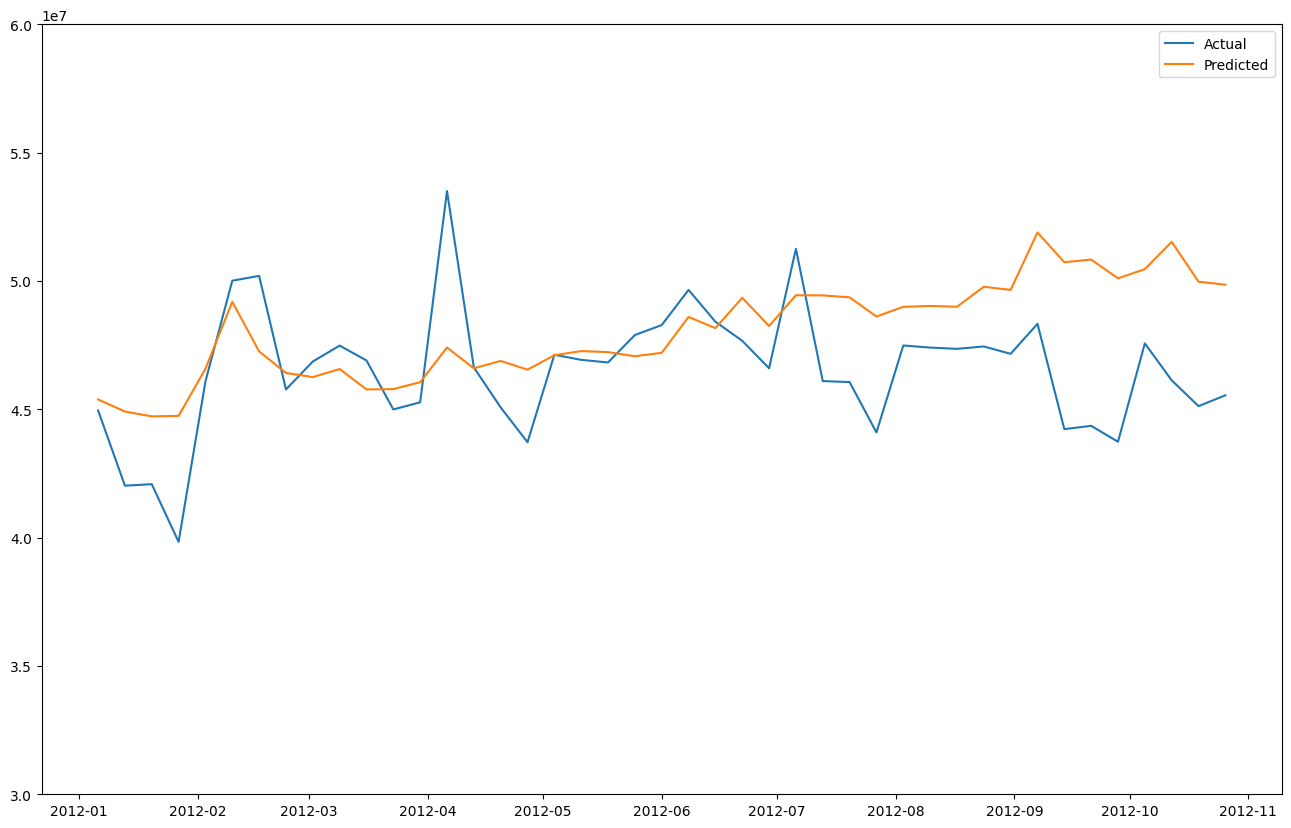

In [13]:
# Plot predict e verdadeiro
plt.figure(figsize=(16,10))
plt.ylim(30000000, 60000000)

plt.plot(df_plot.Date, df_plot.Weekly_Sales, label = "Actual")
plt.plot(df_plot.Date, df_plot.Weekly_Sales_Pred, label = "Predicted")

plt.legend()
plt.show()

In [14]:
r2_score(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Pred'])

0.08871628570929424

In [15]:
mean_absolute_error(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Pred'])

14565.518845941704

In [16]:
mean_squared_error(y_true=df_test['Weekly_Sales'],
                   y_pred=df_test['Weekly_Sales_Pred'])

445904419.0314551

------------------------------------------------------------------------------

### Modelo SVM (Não Linear)

In [6]:
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
X_train = df_train[['day_circle_x', 'day_circle_y', 'IsHoliday', 'Store', 'Size', 'Dept', 'MarkDown5']]
y_train = df_train.Weekly_Sales

X_test = df_test[['day_circle_x', 'day_circle_y', 'IsHoliday', 'Store', 'Size', 'Dept', 'MarkDown5']]
y_test = df_test.Weekly_Sales

In [8]:
# Criando pipeline com standard scale
clf = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))

# Fit inicial do modelo da parcela do treino
clf = clf.fit(X_train, y_train)

# Prevendo vendas
y_pred = clf.predict(X_test)

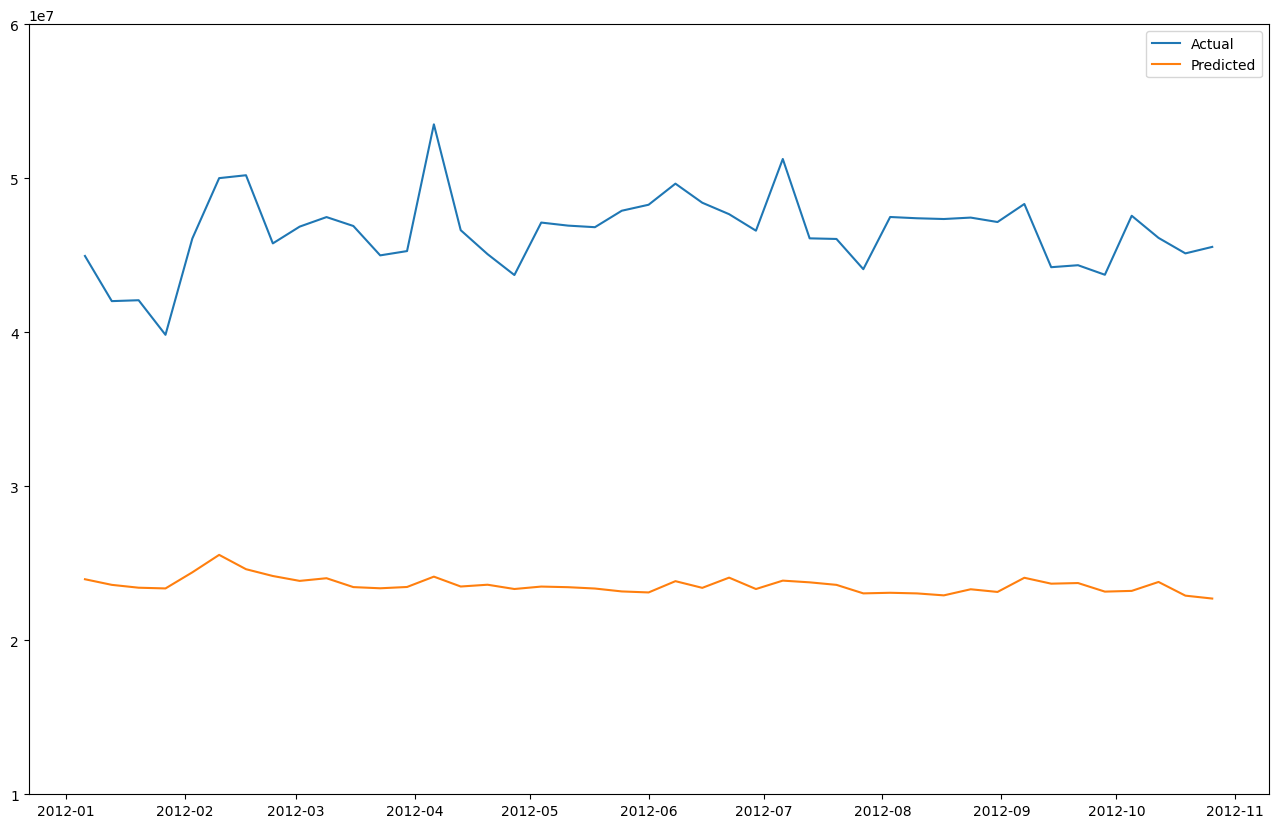

In [9]:
# PLottando resultados
df_test['Weekly_Sales_Pred'] = y_pred
df_plot = df_test[['Date', 'Weekly_Sales', 'Weekly_Sales_Pred']].groupby(['Date']).sum().reset_index()

# Plot predict e verdadeiro
plt.figure(figsize=(16,10))
plt.ylim(10000000, 60000000)

plt.plot(df_plot.Date, df_plot.Weekly_Sales, label = "Actual")
plt.plot(df_plot.Date, df_plot.Weekly_Sales_Pred, label = "Predicted")

plt.legend()
plt.show()

In [10]:
clf.score(X_train, y_train)

-0.0763413816524805

-----------------------------------------

### SGD Regressor

In [11]:
from sklearn.linear_model import SGDRegressor

In [79]:
# Declarando regressor
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-2, learning_rate='optimal'))

# Fit inicial dos parâmetros
reg = reg.fit(X_test, y_test)

# Prevendo vendas
y_pred = reg.predict(X_test)

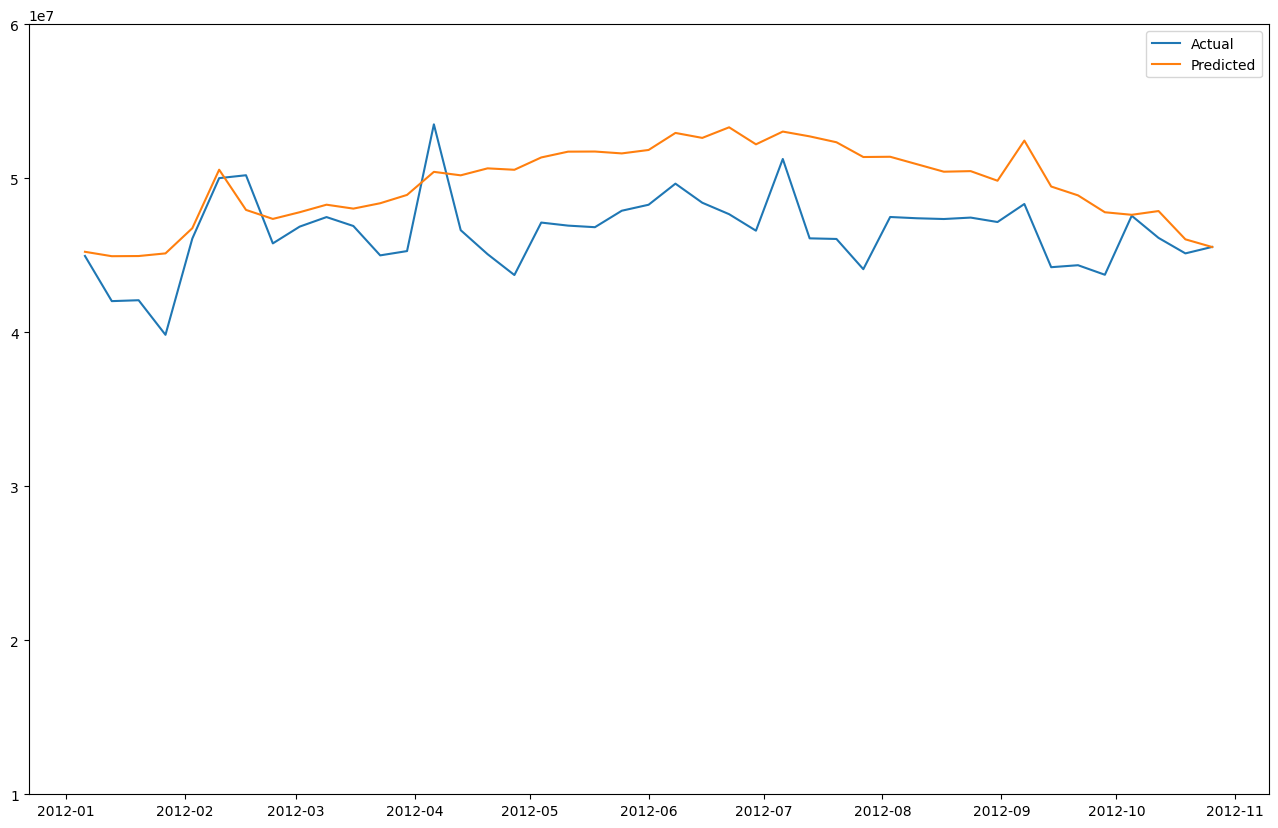

In [80]:
# PLottando resultados
df_test['Weekly_Sales_Pred'] = y_pred
df_plot = df_test[['Date', 'Weekly_Sales', 'Weekly_Sales_Pred']].groupby(['Date']).sum().reset_index()

# Plot predict e verdadeiro
plt.figure(figsize=(16,10))
plt.ylim(10000000, 60000000)

plt.plot(df_plot.Date, df_plot.Weekly_Sales, label = "Actual")
plt.plot(df_plot.Date, df_plot.Weekly_Sales_Pred, label = "Predicted")

plt.legend()
plt.show()

In [81]:
reg.score(X_train, y_train)

0.07790961497319304

-------------------------------------------------------

### Modelo Escolhido: Regressão Linear

In [17]:
df_model

,Date,IsHoliday,Store,Size,Dept,MarkDown5,Weekly_Sales,day_of_year,day_circle_x,day_circle_y,Month,Week
0,2010-02-05,0,1,151315,1,0.00,24924.50,36,0.814292,0.580455,2,5
1,2010-02-05,0,1,151315,2,0.00,50605.27,36,0.814292,0.580455,2,5
2,2010-02-05,0,1,151315,3,0.00,13740.12,36,0.814292,0.580455,2,5
3,2010-02-05,0,1,151315,4,0.00,39954.04,36,0.814292,0.580455,2,5
4,2010-02-05,0,1,151315,5,0.00,32229.38,36,0.814292,0.580455,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,2012-10-26,0,45,118221,93,858.33,2487.80,300,0.433469,-0.901169,10,43
421566,2012-10-26,0,45,118221,94,858.33,5203.31,300,0.433469,-0.901169,10,43
421567,2012-10-26,0,45,118221,95,858.33,56017.47,300,0.433469,-0.901169,10,43
421568,2012-10-26,0,45,118221,97,858.33,6817.48,300,0.433469,-0.901169,10,43


In [29]:
# Treinando modelo sobre o dataset base
X_train = df_model[['day_of_year', 'IsHoliday', 'Store', 'Size', 'Dept']]
y_train = df_model.Weekly_Sales

In [30]:
# Iniciando modelo
reg = LinearRegression().fit(X_train, y_train)

In [31]:
reg.score(X_train, y_train)

0.08445325976736706

In [35]:
# Pegando dataset a ser previsto
df_test = pd.read_csv('../data/raw/test.csv')

# Cruzando com demais informações das bases raw
df_stores = pd.read_csv('../data/raw/stores.csv')
df_test = df_test.merge(df_stores.drop(columns=['Type']), how='left', on=['Store'])

# Adicionando feature extra de dia do ano
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['day_of_year'] = df_test.apply(lambda row: row['Date'].timetuple().tm_yday, axis=1)

# Display
df_test.head(10)

,Store,Dept,Date,IsHoliday,Size,day_of_year
0,1,1,2012-11-02,False,151315,307
1,1,1,2012-11-09,False,151315,314
2,1,1,2012-11-16,False,151315,321
3,1,1,2012-11-23,True,151315,328
4,1,1,2012-11-30,False,151315,335
5,1,1,2012-12-07,False,151315,342
6,1,1,2012-12-14,False,151315,349
7,1,1,2012-12-21,False,151315,356
8,1,1,2012-12-28,True,151315,363
9,1,1,2013-01-04,False,151315,4


In [39]:
# Prevendo
y_pred = reg.predict(df_test[['day_of_year', 'IsHoliday', 'Store', 'Size', 'Dept']])

# Adicionando ao df original
df_test['Weekly_Sales'] = y_pred

# Display
df_test.head(10)

,Store,Dept,Date,IsHoliday,Size,day_of_year,Weekly_Sales
0,1,1,2012-11-02,False,151315,307,14872.765558
1,1,1,2012-11-09,False,151315,314,14915.656629
2,1,1,2012-11-16,False,151315,321,14958.547699
3,1,1,2012-11-23,True,151315,328,15803.672531
4,1,1,2012-11-30,False,151315,335,15044.329841
5,1,1,2012-12-07,False,151315,342,15087.220911
6,1,1,2012-12-14,False,151315,349,15130.111982
7,1,1,2012-12-21,False,151315,356,15173.003052
8,1,1,2012-12-28,True,151315,363,16018.127884
9,1,1,2013-01-04,False,151315,4,13016.194932


In [52]:
df_test.to_csv('../data/df_predicted.csv', index=False, sep=';')